### Predict next track using RNN from Steve

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
torch.__version__

'0.4.0'

In [3]:
from trackml.dataset import load_event
from trackml.randomize import shuffle_hits
from trackml.score import score_event

In [4]:
import os
import numpy as np
import pandas as pd
import glob
import math


import time
from utils import timeSince
from tqdm import tqdm

In [5]:

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline


In [6]:
class HitGausPredictor(nn.Module):
    """
    A PyTorch module for particle track state estimation and hit prediction.

    This module is an RNN which takes a sequence of hits and produces a
    Gaussian shaped prediction for the location of the next hit.
    """

    def __init__(self, hidden_dim=5, batch_size=64, device=None):
        super(HitGausPredictor, self).__init__()
        input_dim = 3
        output_dim = 2
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
#         out_size = int(output_dim * (output_dim + 3) / 2)
        out_size = 4
        self.fc = nn.Linear(hidden_dim, out_size)
        self.device = device
        self.batch_size = batch_size
        

    def forward(self, x):
        """Might want to accept also the radius of the target layer."""
        input_size = x.size()

        # Initialize the LSTM hidden state
        h = (torch.zeros(self.lstm.num_layers, self.batch_size, self.lstm.hidden_size, device=self.device),
             torch.zeros(self.lstm.num_layers, self.batch_size, self.lstm.hidden_size, device=self.device))
        
        # Apply the LSTM module
        x, h = self.lstm(x, h)
        # Squash layer axis into batch axis
        x = x.contiguous().view(-1, x.size(-1))

        # Apply linear layer
        output = self.fc(x)
        
        # Extract and transform the gaussian parameters
        means = output[:, :2]
        variances = output[:, 2:4].exp() ## ensure it is positive

        # Expand the layer axis again, just for consistency/interpretability
        means = means.contiguous().view(self.batch_size, -1, 2)
        variances = variances.contiguous().view(self.batch_size, -1, 2)
        return means, variances

In [23]:
def gaus_llh_loss(outputs, targets):
    """Custom gaussian log-likelihood loss function"""
    means, covs = outputs
    
#     means = means_[:, 1:, :]
#     covs = covs_[:, 1:, :]
        
    batches = means.size(0)
    hits = means.size(1)
    

    # Flatten layer axis into batch axis to use batch matrix operations
    means = means.contiguous().view(means.size(0)*means.size(1), means.size(2))
    covs = covs.contiguous().view(covs.size(0)*covs.size(1), covs.size(2))
    targets = targets.contiguous().view(targets.size(0)*targets.size(1),
                                        targets.size(2))
    

#     # Calculate the residual error
    res = targets - means
    prob = res*res / (2*covs) + covs.log()
#     logdet = 2 * torch.logdet(covs)

    prob = prob.contiguous().view(batches, hits, -1)

    return torch.sum(prob)/batches/hits

In [8]:
import pickle
track_list_raw = pickle.load(open('ten_hists.npy', 'rb'))

In [9]:
for event in track_list_raw:
    for tracks in event:
        tracks[:, 0] = (tracks[:, 0] - 913.681763)/692.430542 # r
        tracks[:, 1] = (tracks[:, 1] - 0.009939)/1.823752     # phi
        tracks[:, 2] = (tracks[:, 2] + 2.315056)/1061.912476  # z

In [10]:
track_arrays = np.concatenate([np.array(x) for x in track_list_raw])
print(track_arrays.shape)

(1594060, 10, 3)


In [11]:
total_samples = track_arrays.shape[0]
n_training = int(total_samples/2) - 1
n_testing = n_training

(array([4647834., 3057007., 2818995., 1920075., 1563611.,  634856.,
         292414.,  280683.,  331239.,  393886.]),
 array([-1.27412415, -0.82725766, -0.38039117,  0.06647532,  0.51334181,
         0.9602083 ,  1.40707479,  1.85394127,  2.30080776,  2.74767425,
         3.19454074]),
 <a list of 10 Patch objects>)

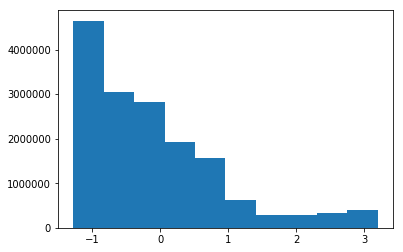

In [12]:
plt.hist(track_arrays[:, :, 0].flatten())

(array([1556086., 1581389., 1622470., 1592891., 1594513., 1599196.,
        1609711., 1625061., 1589822., 1569461.]),
 array([-1.72804821, -1.38352851, -1.03900881, -0.69448911, -0.34996941,
        -0.00544971,  0.33906999,  0.68358968,  1.02810938,  1.37262908,
         1.71714878]),
 <a list of 10 Patch objects>)

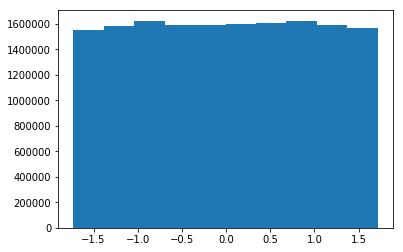

In [13]:
plt.hist(track_arrays[:, :, 1].flatten())

(array([ 352654.,  439244.,  961281., 2167184., 4046045., 3987389.,
        2192277.,  970643.,  451412.,  372471.]),
 array([-2.78100610e+00, -2.22436888e+00, -1.66773167e+00, -1.11109445e+00,
        -5.54457235e-01,  2.17998028e-03,  5.58817196e-01,  1.11545441e+00,
         1.67209163e+00,  2.22872884e+00,  2.78536606e+00]),
 <a list of 10 Patch objects>)

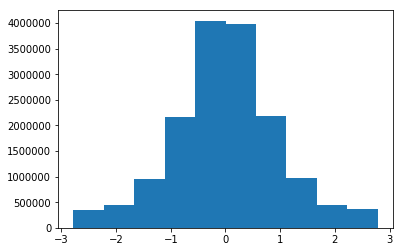

In [14]:
plt.hist(track_arrays[:, :, 2].flatten())

In [15]:
batch_size = 64

In [27]:
from utils import random_choice
import random
def random_input():
    event = random_choice(track_list[0:1000])
    rand_start = random.randint(0, len(event)-batch_size-1)
    input = np.array(event[rand_start:rand_start+batch_size])
    input_t = torch.from_numpy(input)
    target_t = torch.from_numpy(input[:, 1:, 1:])
    return input_t, target_t

In [16]:
model = HitGausPredictor(batch_size=batch_size)
optimizer = optim.Adam(model.parameters())

In [165]:
input_t = torch.from_numpy(np.array(track_list[0][0:64]))
print(input_t.size())
output = model(input_t)
gaus_llh_loss(output, torch.from_numpy(np.array(track_list[0][0:64])[:, 1:, :2]) )

torch.Size([64, 10, 3])


In [17]:
from utils import tunable_parameters

In [18]:
print('total tunable parameters:', tunable_parameters(model))

total tunable parameters: 224


In [19]:
def train(n_epochs):
    loss_train = []
#     save_every = int(n_epochs/50)
    save_every = 1
    for i in tqdm(range(n_epochs)):
        
        sum_loss = 0.
        
        nbatches = int(n_training/batch_size)
        if i==0:
            print("number of batches:", nbatches)
        for ibatch in range(nbatches):
            start = ibatch*batch_size
            end = start + batch_size

            input = track_arrays[start:end]
            input_t = torch.from_numpy(input[:, :-1, :])
            target_t = torch.from_numpy(input[:, 1:, 1:])
    
        
            model.zero_grad()
            output_t = model(input_t)
            loss = gaus_llh_loss(output_t, target_t)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()
        
        if (i % save_every == 0):
            loss_train.append(sum_loss/nbatches)
    return loss_train

In [ ]:
res = train(50)

  0%|          | 0/50 [00:00<?, ?it/s]

number of batches: 12453


In [50]:
res

[7.558638960839821, 6.439584875375505e-08]

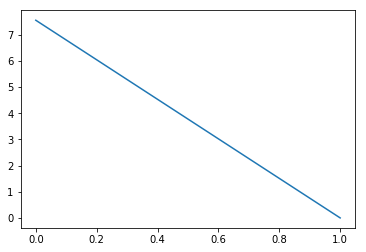

In [49]:
plt.plot(np.arange(0, len(res)), res)

In [51]:
def cal_res(test_track):
    test_t = torch.from_numpy(test_track)
    target_t = torch.from_numpy(test_track[:, 1:, 1:])
    with torch.no_grad():
        means, covs = model(test_t)
        means = means[:, 1:, :]
        covs = covs[:, 1:, :]
        
        means = means.contiguous().view(means.size(0)*means.size(1), means.size(2))
        covs = covs.contiguous().view(covs.size(0)*covs.size(1), covs.size(2))
        target_t = target_t.contiguous().view(target_t.size(0)*target_t.size(1),
                                        target_t.size(2))
        
        res = means - target_t
        return res, covs

In [52]:
test_t = torch.from_numpy(track_arrays[0:64])

In [53]:
test_t[0]

tensor([[-1.2701, -1.1424, -0.0093],
        [-1.2081, -1.1301, -0.0236],
        [-1.1392, -1.1152, -0.0394],
        [-1.0531, -1.0962, -0.0591],
        [-0.9184, -1.0665, -0.0905],
        [-0.7677, -1.0334, -0.1253],
        [-0.5403, -0.9821, -0.1788],
        [-0.2930, -0.9249, -0.2383],
        [-0.0574, -0.8675, -0.2939],
        [ 0.2695, -0.7842, -0.3807]])

In [54]:
with torch.no_grad():
    output = model(test_t)

In [288]:
print(output[0][0])

tensor([[ 1.0592e-02,  4.6782e+02],
        [-1.0219e-02,  2.5565e+02],
        [-2.0312e-02,  3.9133e+02],
        [-2.5424e-02,  5.5890e+02],
        [-2.6622e-02,  9.7297e+02],
        [-2.7319e-02,  1.2263e+03],
        [-2.7553e-02,  1.3074e+03],
        [-2.7611e-02,  1.3258e+03],
        [-2.7623e-02,  1.3293e+03],
        [-2.7626e-02,  1.3299e+03]])


In [289]:
t_t = torch.from_numpy(np.array(track_list[900][0:64])[:, 1:, 1:])
print(gaus_llh_loss(output, t_t))

tensor(75.6991)


In [ ]:
print(n)

In [55]:
residule, covs = cal_res(np.array(track_list[800][0:64]))

In [56]:
res_phi = residule.numpy()[:, 0].reshape(residule.size(0))
res_z = residule.numpy()[:, 1].reshape(residule.size(0))

(array([  3.,   3.,   8., 404., 139.,  11.,   3.,   3.,   1.,   1.]),
 array([-0.00189257, -0.00136727, -0.00084198, -0.00031668,  0.00020862,
         0.00073391,  0.00125921,  0.0017845 ,  0.0023098 ,  0.00283509,
         0.00336039]),
 <a list of 10 Patch objects>)

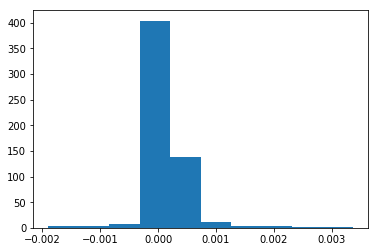

In [57]:
plt.hist(res_phi)

(array([  1.,   0.,   2.,   2.,  35., 283., 214.,  34.,   3.,   2.]),
 array([-5.66482544e-03, -4.70435619e-03, -3.74388695e-03, -2.78341770e-03,
        -1.82294846e-03, -8.62479210e-04,  9.79900360e-05,  1.05845928e-03,
         2.01892853e-03,  2.97939777e-03,  3.93986702e-03]),
 <a list of 10 Patch objects>)

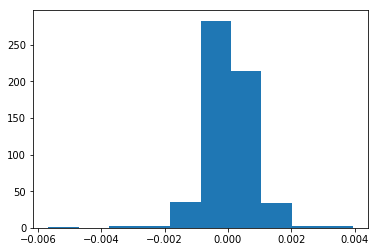

In [58]:
plt.hist(res_z)

/global/project/projectdirs/m1092/xju/miniconda3/envs/py3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/global/project/projectdirs/m1092/xju/miniconda3/envs/py3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


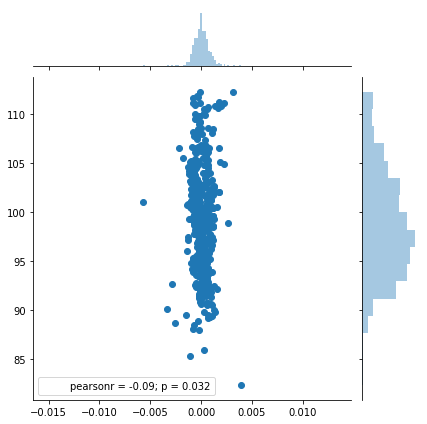

In [59]:
a = residule.numpy()[:, 1]
b = covs.numpy()[:, 1]
sns.jointplot(a, b)

/global/project/projectdirs/m1092/xju/miniconda3/envs/py3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/global/project/projectdirs/m1092/xju/miniconda3/envs/py3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


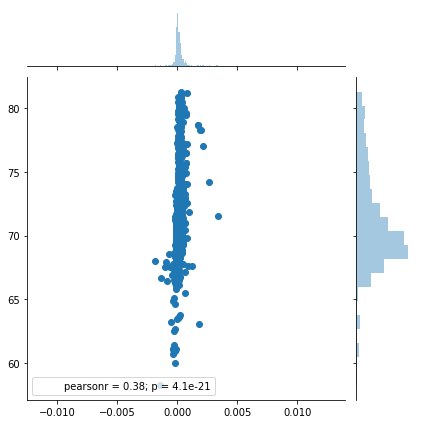

In [60]:
a = residule.numpy()[:, 0]
b = covs.numpy()[:, 0]
sns.jointplot(a, b)

In [61]:
print(total_samples)

1594060


In [62]:
residule, covs = cal_res(track_arrays[894060:894060+64])

In [64]:
res_phi = residule.numpy()[:, 0]
res_z = residule.numpy()[:, 1]

(array([  1.,   2.,  11., 510.,  48.,   2.,   0.,   0.,   0.,   2.]),
 array([-3.13116689e-05, -2.23488769e-05, -1.33860849e-05, -4.42329292e-06,
         4.53949906e-06,  1.35022910e-05,  2.24650830e-05,  3.14278750e-05,
         4.03906670e-05,  4.93534590e-05,  5.83162509e-05]),
 <a list of 10 Patch objects>)

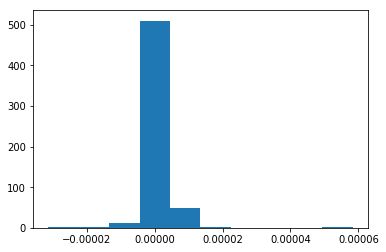

In [70]:
plt.hist(res_phi/covs.numpy()[:, 0])

(array([  1.,   2.,  43., 502.,  25.,   1.,   0.,   0.,   1.,   1.]),
 array([-0.00200343, -0.00137917, -0.0007549 , -0.00013064,  0.00049362,
         0.00111789,  0.00174215,  0.00236641,  0.00299067,  0.00361494,
         0.0042392 ]),
 <a list of 10 Patch objects>)

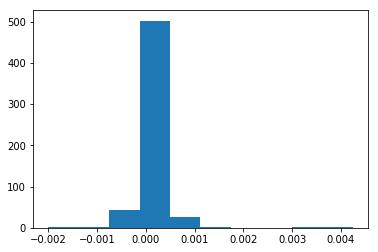

In [69]:
plt.hist(res_phi)

(array([  1.,   0.,   0.,   5., 105., 327., 116.,  18.,   2.,   2.]),
 array([-0.00486994, -0.00399179, -0.00311365, -0.00223551, -0.00135736,
        -0.00047922,  0.00039892,  0.00127707,  0.00215521,  0.00303335,
         0.0039115 ]),
 <a list of 10 Patch objects>)

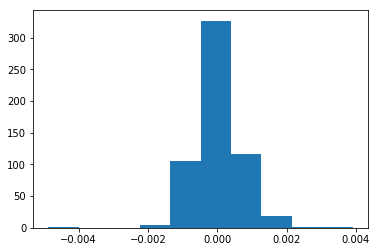

In [66]:
plt.hist(res_z)

/global/project/projectdirs/m1092/xju/miniconda3/envs/py3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/global/project/projectdirs/m1092/xju/miniconda3/envs/py3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


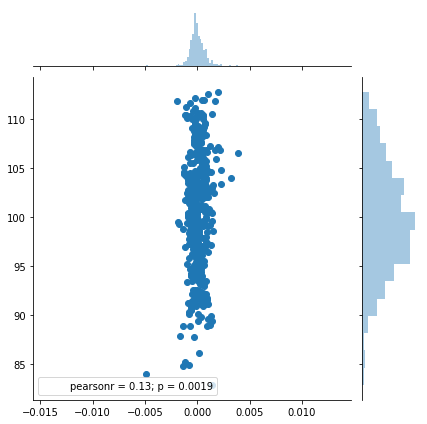

In [67]:
a = residule.numpy()[:, 1]
b = covs.numpy()[:, 1]
sns.jointplot(a, b)

/global/project/projectdirs/m1092/xju/miniconda3/envs/py3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/global/project/projectdirs/m1092/xju/miniconda3/envs/py3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


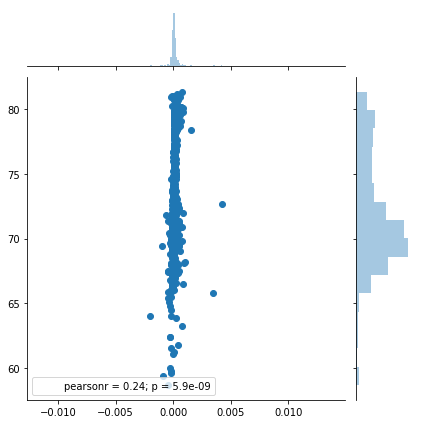

In [68]:
a = residule.numpy()[:, 0]
b = covs.numpy()[:, 0]
sns.jointplot(a, b)

In [51]:
target_t = torch.from_numpy(np.array(track_list[0:64])[:, 1:, :2])

In [26]:
input_t.size()

torch.Size([64, 10, 3])

In [80]:
target_t.size()

torch.Size([64, 9, 2])

In [32]:
loss_func = gaus_llh_loss

In [72]:
model = HitGausPredictor()
output = model(input_t)
print(output[0].size())
print(output[1].size())

torch.Size([64, 10, 2])
torch.Size([64, 10, 2, 2])


In [78]:
gaus_llh_loss(output, target_t)

torch.Size([64, 9, 2])
torch.Size([64, 9, 2, 2])


tensor(4.9554e+08)

In [ ]:
particles[particles['nhits'] == 10]

In [10]:
hits, cells, particles, truth = load_event("input/train_1/event000001000")

In [11]:
from utils import get_features
hits_features = get_features(hits)

In [12]:
hits_features['phi'].describe()

count    120939.000000
mean          0.009939
std           1.823752
min          -3.141573
25%          -1.572897
50%           0.023993
75%           1.604743
max           3.141564
Name: phi, dtype: float64

In [13]:
hits_features['z'].describe()

count    120939.000000
mean         -2.315056
std        1061.912476
min       -2955.500000
25%        -655.799988
50%          -1.800000
75%         655.799988
max        2955.500000
Name: z, dtype: float64

In [14]:
hits_features['r'].describe()

count    120939.000000
mean        913.681763
std         692.430542
min          31.440248
25%         383.521042
50%         818.536621
75%        1242.431213
max        3125.336670
Name: r, dtype: float64

In [16]:
hits_features['j'] = (hits_features['r'] - 913.681763)/692.430542

In [17]:
hits_features['j'].describe()

count    1.209390e+05
mean     5.652385e-08
std      1.000000e+00
min     -1.274123e+00
25%     -7.656518e-01
50%     -1.374075e-01
75%      4.747761e-01
max      3.194046e+00
Name: j, dtype: float64